In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
"""

In [11]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
name   ="M1_hazirVeri_toplu_2008-2022_dongulu"
#df=pd.read_csv("EURUSD.csv")
df = pd.read_csv('/content/drive/Othercomputers/2022 Masaüstü 2/Dersler 2022/Dersler-2021-2022-Donem-2/Lisans Github/EURUSD_'+name+'.csv', engine='python')
    
print("Number of rows and columns:", df.shape)
#df = df.drop('Adj Close',axis=1)
#df = df.drop('Volume',axis=1)
df.tail(10)

Number of rows and columns: (1048575, 7)


,Index,Open,High,Low,Close,sin,cos
1048565,1048565,1.37663,1.37665,1.37650,1.37660,-0.38249,1.27099
1048566,1048566,1.37659,1.37747,1.37655,1.37738,-0.48360,1.29808
1048567,1048567,1.37740,1.37741,1.37704,1.37711,-0.58132,1.33559
1048568,1048568,1.37711,1.37716,1.37675,1.37675,-0.67458,1.38311
1048569,1048569,1.37674,1.37679,1.37652,1.37652,-0.76237,1.44012
1048570,1048570,1.37654,1.37694,1.37654,1.37670,-0.84371,1.50600
1048571,1048571,1.37669,1.37673,1.37657,1.37661,-0.91772,1.58001
1048572,1048572,1.37662,1.37684,1.37654,1.37682,-0.98360,1.66135
1048573,1048573,1.37682,1.37686,1.37668,1.37678,-1.04061,1.74914
1048574,1048574,1.37682,1.37687,1.37670,1.37670,-1.08813,1.84240


In [12]:
train_size = ((len(df)*90)//100)
training_set = df.iloc[:train_size, 1:2].values
test_set = df.iloc[train_size:, 1:2].values

train_size,training_set[:5],test_set[:5]

(943717, array([[1.4076],
        [1.4074],
        [1.4076],
        [1.4081],
        [1.4083]]), array([[1.44784],
        [1.44815],
        [1.4484 ],
        [1.44836],
        [1.4485 ]]))

In [16]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

time_steps_train = 2

# Creating a data structure with 2 time-steps and 1 output
X_train = []
y_train = []
for i in range(time_steps_train, train_size):
    X_train.append(training_set_scaled[i-time_steps_train:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [ ]:
# Getting the predicted
dataset_train = df.iloc[:train_size, 1:2]
dataset_test = df.iloc[train_size:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps_train:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps_train, len(df)-train_size+time_steps_train): #519
    X_test.append(inputs[i-time_steps_train:i, 0])
    y_test.append(inputs[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
print(X_test.shape,y_test.shape)
#(459, 60, 1)

In [20]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

In [21]:
model.fit(X_train, y_train, epochs = 10, batch_size = 4096)

Epoch 1/10
231/231 [==============================] - 41s 139ms/step - loss: 0.0165
Epoch 2/10
231/231 [==============================] - 32s 139ms/step - loss: 7.9717e-04
Epoch 3/10
231/231 [==============================] - 32s 139ms/step - loss: 6.4832e-04
Epoch 4/10
231/231 [==============================] - 32s 139ms/step - loss: 5.4469e-04
Epoch 5/10
231/231 [==============================] - 32s 140ms/step - loss: 4.8024e-04
Epoch 6/10
231/231 [==============================] - 32s 139ms/step - loss: 4.4370e-04
Epoch 7/10
231/231 [==============================] - 32s 138ms/step - loss: 4.2195e-04
Epoch 8/10
231/231 [==============================] - 32s 138ms/step - loss: 4.0838e-04
Epoch 9/10
231/231 [==============================] - 32s 139ms/step - loss: 3.9648e-04
Epoch 10/10
231/231 [==============================] - 32s 139ms/step - loss: 3.8716e-04


In [22]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

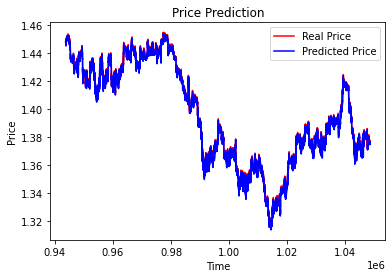

In [23]:
# Visualising the results
plt.plot(df.loc[train_size:, "Index"],dataset_test.values, color = "red", label = "Real Price")
plt.plot(df.loc[train_size:, "Index"],predicted_stock_price, color = "blue", label = "Predicted Price")
#plt.xticks(np.arange(0,len(df),50))
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()